У цьому ДЗ ми попрактикуємось моделювати часові ряди на даних з [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). Ми будемо працювати лише з тренувальними даними цього змагання і задача у нас буде дещо змінена. Фокус буде на пошуці найкращої моделі, експериментах і використанні функціоналу `darts`.

Якщо якісно попрацювати в цьому завданні - це буде чудовий приклад проєкту для вашого портфоліо: "спрогнозував(-ла) поденні продажі на 1 міс для 50 товарів в 10 магазинах" звучить вражаюче! Але ми в рамках ДЗ для оптимізації часу сконцентруємось на моделюванні продажів одного товару в одному магазині.

**Задача**

Вам надано дані про продажі товарів у магазинах за 5 років. Хочемо навчитись передачати продажі в наступному місяці поденно кожного з 50 товарів у кожному з 10 магазинів. Відповідно будемо проводити експерименти, аби знайти найкращу модель для цього.

На відміну від змагання, ми будемо використовувати метрику МАРЕ (Mean Absolute Percentage Error) замість SMAPE (Symmetric Mean Absolute Percentage Error). Проте, ви також можете розрахувати SMAPE і подати свої результати через late submission на Kaggle.

1. Завантажуємо дані в Pandas.

  1. Завантажте дані з файлу `train.csv.zip` за допомогою бібліотеки Pandas.
  2. Перетворіть колонку `date` на формат `datetime`.
  3. Встановіть колонку `date` як індекс для датафрейму.
  4. Виведіть перші 10 рядків отриманого датафрейму та інформацію про датафрейм.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import darts
import plotly.express as px

In [2]:
df = pd.read_csv('train.csv.zip', compression='zip')
df['date'] = pd.to_datetime(df['date'])
print(f'Data column type: {df['date'].dtype}')
df = df.set_index('date')
df.iloc[:10]

Data column type: datetime64[ns]


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


  2. Давайте трошки зрозуміємо дані. У нас 10 магазинів і 50 айтемів в кожному. Хочемо зрозуміти, чи відрізняється динаміка по кожному айтему в магазинах. Як би ви це візуалізували? Побудуйте 3 графіка, які вам допоможуть. Можна використати будь-який інструмент: matplotlib, seaborn, plotly.

  Напишіть висновок з побудованих вами візуалізацій.
  
    **Підказка**: я б спробувала вивести середнє значення і довірчий інтервал (який включає весь діапазон значень з різних магазинів) для динаміки кожного айтема, або принаймні для декількох айтемів, аби зрозуміти тенденцію.



<Figure size 2000x2000 with 0 Axes>

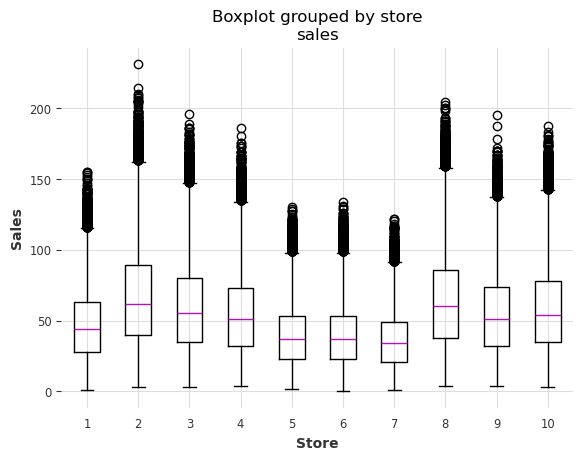

In [3]:
plt.figure(figsize=(20, 20))
df.boxplot(column='sales', by='store')
plt.xlabel('Store')
plt.ylabel('Sales')
plt.show()


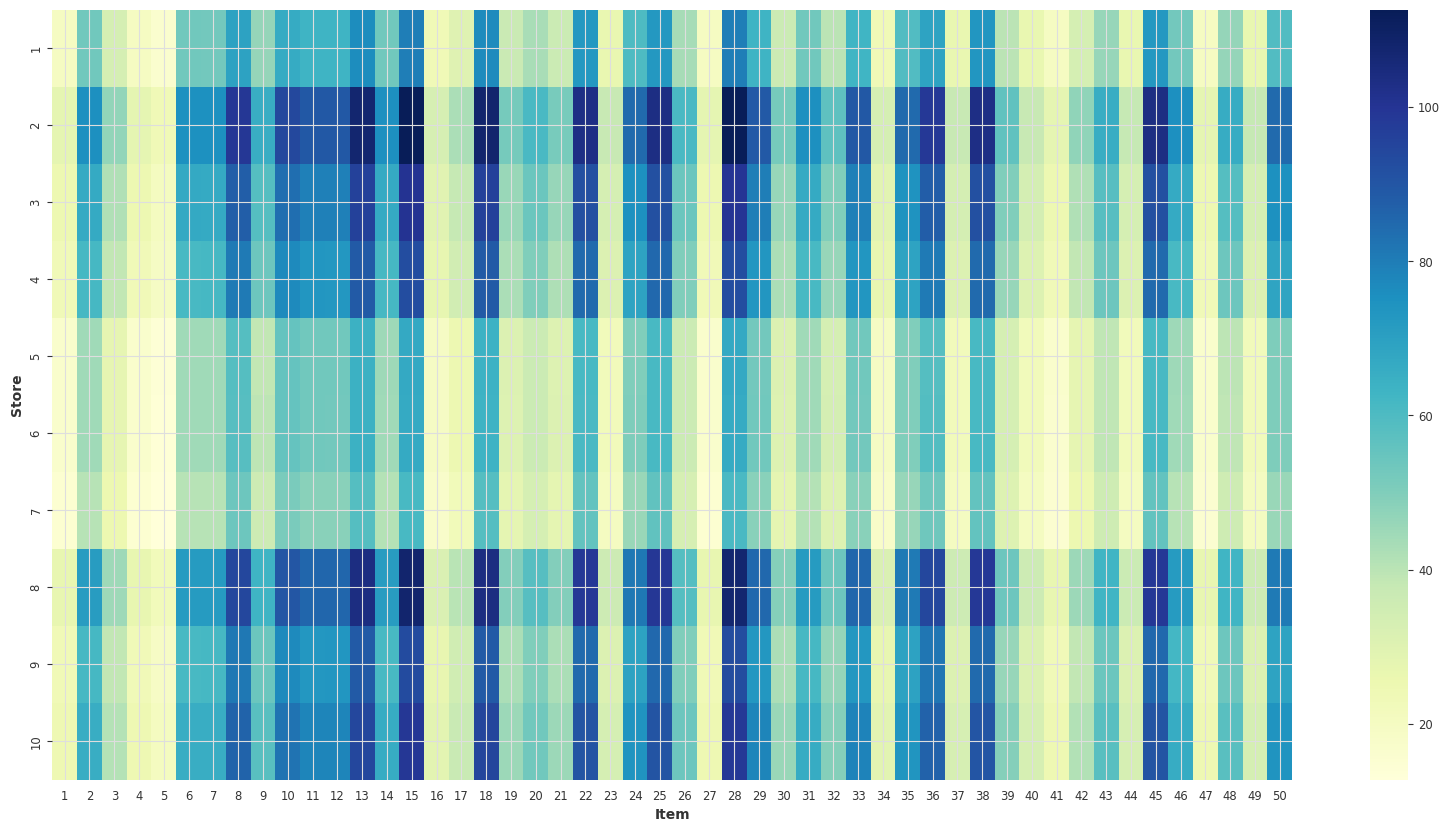

In [422]:
mean_sales = df.groupby(['store', 'item'])['sales'].mean().reset_index()
mean_sales = mean_sales.pivot(index='store', columns='item', values='sales')
mean_sales = mean_sales.sort_values(by='store')
plt.figure(figsize=(20, 10))
sns.heatmap(mean_sales, cmap='YlGnBu')
plt.xlabel('Item')
plt.ylabel('Store')
plt.show()

In [423]:
description = df.groupby(['date', 'item']).agg(
    avg_sales=('sales', 'mean'),
    min_sales=('sales', 'min'),
    max_sales=('sales', 'max'),
    total_sales=('sales', 'sum')
).reset_index()
description


,date,item,avg_sales,min_sales,max_sales,total_sales
0,2013-01-01,1,13.3,7,20,133
1,2013-01-01,2,32.7,21,43,327
2,2013-01-01,3,17.2,9,26,172
3,2013-01-01,4,10.2,4,21,102
4,2013-01-01,5,8.3,4,13,83
...,...,...,...,...,...,...
91295,2017-12-31,46,60.5,35,79,605
91296,2017-12-31,47,21.1,12,29,211
91297,2017-12-31,48,49.4,32,64,494
91298,2017-12-31,49,28.5,12,44,285


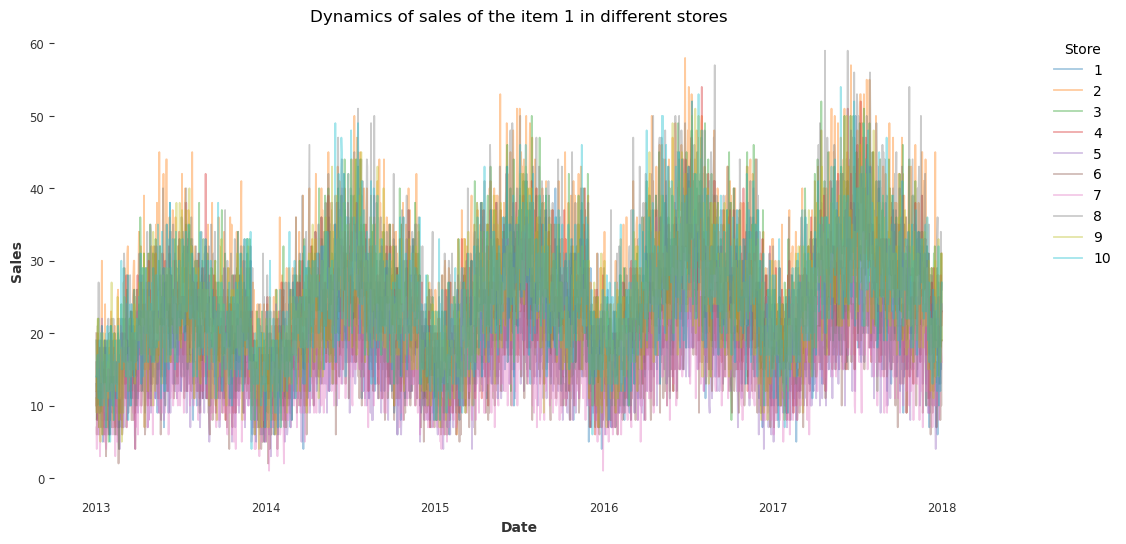

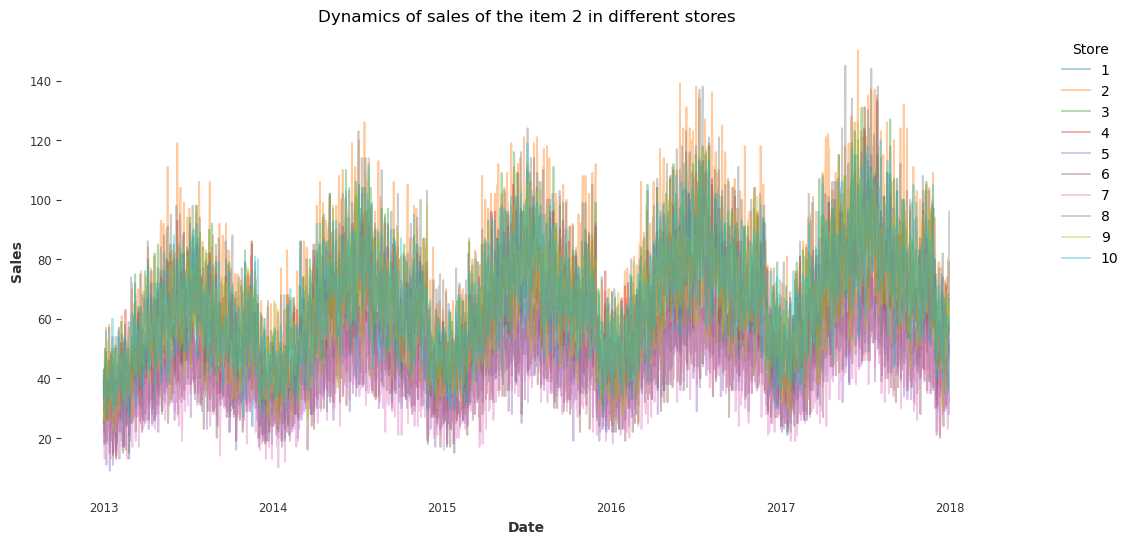

In [424]:
# unique_items = df['item'].unique()
# for item_to_plot in unique_items:

for item_to_plot in range(1, 3):
    df_item = df[df['item'] == item_to_plot]
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_item, x=df_item.index, y='sales', hue='store', palette='tab10', alpha=0.4)
    plt.title(f'Dynamics of sales of the item {item_to_plot} in different stores')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend(title='Store', loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid()
    plt.show()


In [ ]:
fig = px.histogram(df, x=df.index, y='sales', title='Sales over time', marginal='box', color='store',  barmode="overlay")
fig.show()

# Висновки 2

- На графіку ми можемо спостерігати чітку сезонність продажів товарів. З піком на літні періоди та з провалом за зимові.
- Також помітно невеликий тренд на збільшення по продажам з роками.
- Також під час піків помітний більша вареабельність продажів по різних магазинах для одного товару, але при цьому патерн поведінки в межах одного товару для всіх магазинів залишається схожим
- По "термальному" графіку видно що деякі магазини демонструють стабільно вищі продажі по всім товарам ( магазин 8 та 2)
- Також бачимо тенденцію що певні товари мають більше попит в цілому такі як товар 15, 18, 22... (вертикальні смуги більш темніші).

Загальний висновок що товари мають схожий патерн поведінки між різними магазинами, але з різною амплітудою. В нас відсутні випакди коли поведінка певного товару\мазагину координально відрізняється.


3. **Для початку проаналізуємо лише один ряд, а далі зможемо зациклити тренування моделей.**
  
  Виберіть підмножину даних, що відповідає продажам товару з `item == 1` у магазині з `store == 1`.

  Зробіть декомпозицію цього рядку за адитивною моделлю на тренд, сезонність і залишки з бібліотекою `statsmodels`.

  Зробіть висновки з отриманих візуалізацій. Чи щось би могло вам допомогти ліпше зрозуміти ці візуалізації? (з точки зору обробки даних)

In [4]:
df_11 = df[(df['store'] == 1) & (df['item'] == 1)]  
print(df_11.item.value_counts(), df_11.store.value_counts())
df_11.head()

item
1    1826
Name: count, dtype: int64 store
1    1826
Name: count, dtype: int64


,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


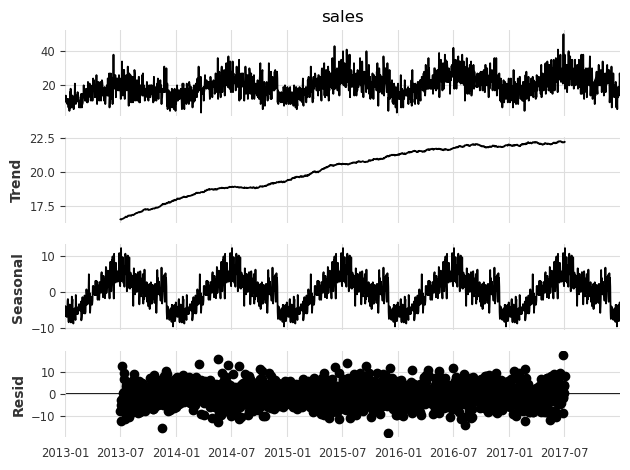

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_additive = seasonal_decompose(df_11['sales'], model='additive', period=365)
decompose_additive.plot()
plt.show()

# Висновки 3

- Маємо підтверджену чутку річну сезонність 
- Тренд даних зростає але дуже повільно
- Також залишки розподілені рандомно в району 0, хоча доволі значна помилка +-10

4. Зі створеної підможени даних в попередньому пункті створіть обʼєкт класу `TimeSeries` в `darts` лише для колонки `sales`.

In [6]:
from darts import TimeSeries

In [7]:
series_darts = TimeSeries.from_dataframe(df_11, value_cols='sales')
series_darts

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

5. Використовуючи метод `series.split_before` розбийте дані на тренування і валідацію так, аби валідація починалась з `2017-10-01` включно.

  Візуалізуйте на одному графіку тренувальну і валідаційну частину як було показано в лекції.

<Axes: xlabel='date'>

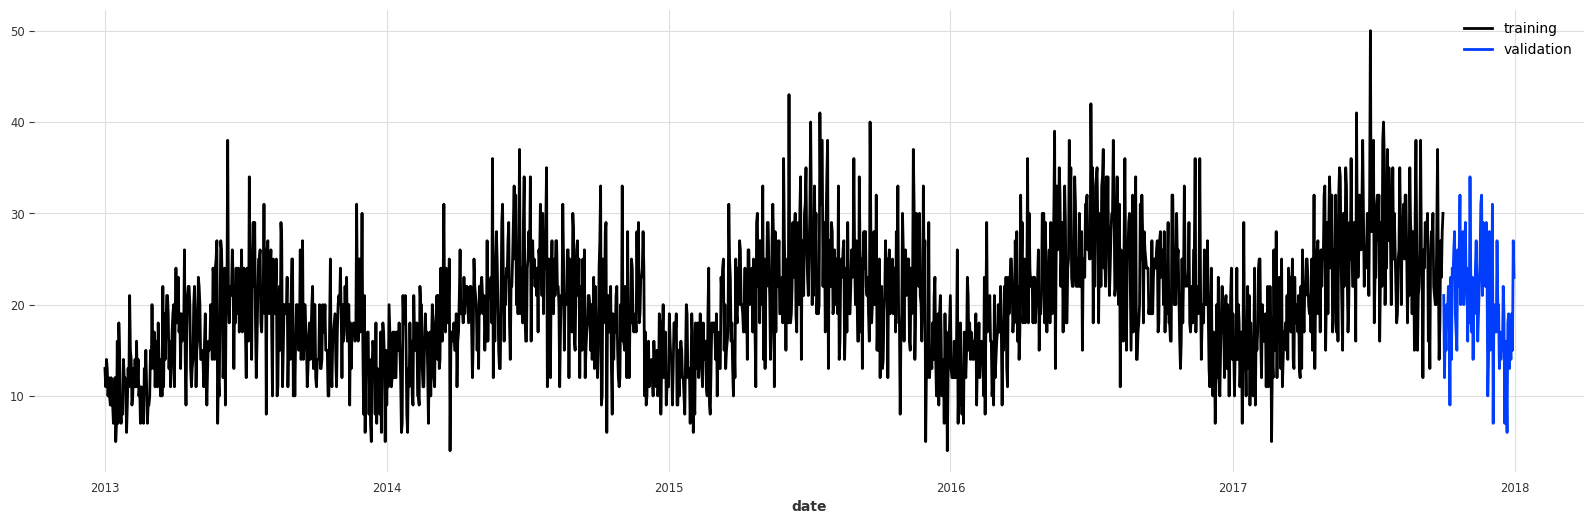

In [8]:
validation_split = '2017-10-01'
train, val = series_darts.split_before(pd.Timestamp(validation_split))

plt.figure(figsize=(20,6))
train.plot(label="training")
val.plot(label="validation")

6. Побудуйте часткову автокореляційну фукнцію для цього нашого ряду в `series`. Напишіть висновки - які лаги є важливими для прогнозування?

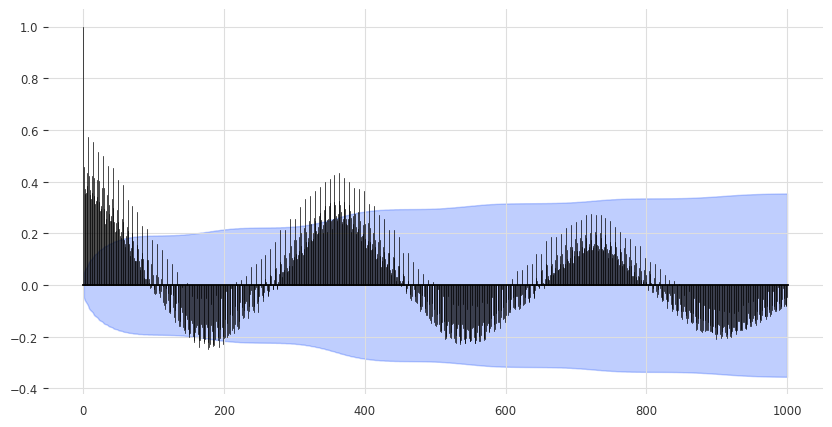

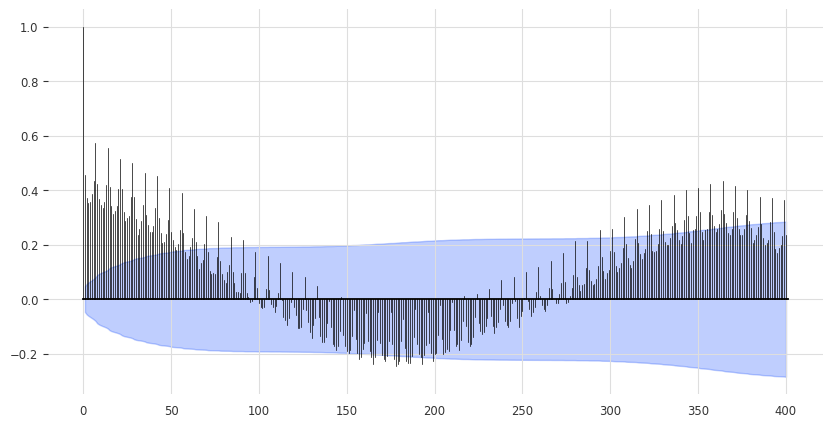

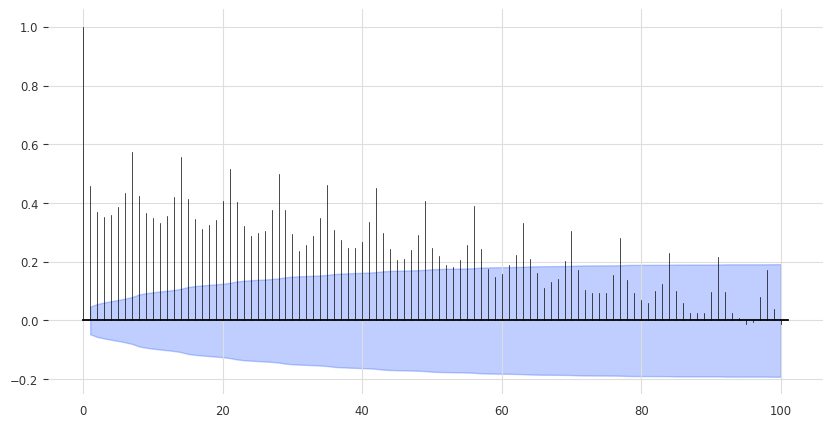

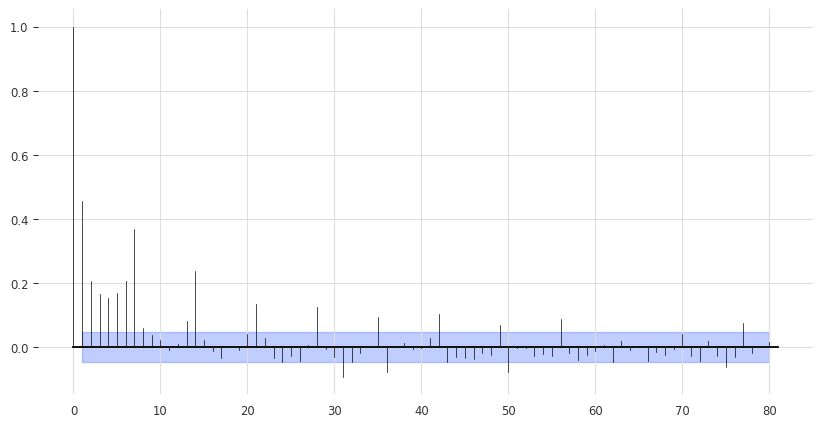

In [8]:
from darts.utils.statistics import plot_acf, check_seasonality, plot_pacf

plot_acf(train, max_lag=1000)
plot_acf(train, max_lag=400)
plot_acf(train, max_lag=100)
plot_pacf(train, max_lag=80)

# Висновки 6
Побудуємо декілька графіків аби дослідити глобальну автокареляцію та більш локальну
- На самому широкому по часі графіку помітна позитивна річна залежність даних приблизно на 300-400 лага
- Також між 150-200 лагами також спостерігається стат знач негативна автокореляція. Це відповідає піврічному терміну, коли ми спостерігаємо спад в наших даних на попередніх графіках
- На більш приближеному графіку ми бачимо наявність тижневої залежності  
- До 50 лага всі компоненти стат значущі. При тому що "тижнева\7-денна" стат.значність залишається навіть до 80го лага.
- По частковій автокореляцій важливим є перші 7 лагів та наступні які кратні 7 

7. Виявіть сезональність тренувального ряду використовуючи фукнкцію `check_seasonality` з `darts`.

In [432]:
for m in range(2, 400):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05 , max_lag=400)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.
There is seasonality of order 28.
There is seasonality of order 35.
There is seasonality of order 42.
There is seasonality of order 49.
There is seasonality of order 56.
There is seasonality of order 63.
There is seasonality of order 70.
There is seasonality of order 74.
There is seasonality of order 77.
There is seasonality of order 84.
There is seasonality of order 91.
There is seasonality of order 98.
There is seasonality of order 105.
There is seasonality of order 112.
There is seasonality of order 119.
There is seasonality of order 126.
There is seasonality of order 133.
There is seasonality of order 224.
There is seasonality of order 231.
There is seasonality of order 238.
There is seasonality of order 245.
There is seasonality of order 252.
There is seasonality of order 259.
There is seasonality of order 266.
There is seasonality of order 273.
There is seasonality of order 280.
T

8. Побудуйте наївну модель NaiveSeasonal + NaieDrift для прогнозування даних. Кількість кроків для прогнозування визначіть зі свого аналізу в попередніх пунктах. Візуалізайте передбачення проти справжніх даних так, аби було видно якість передбачень. Зробіть висновок про модель. Вона точна?

  Якщо у вас є ідеї, як поліпшити якість передбачення саме наївними моделями - реалізуйте їх в цьому пункті :)

In [9]:
from darts.models import NaiveSeasonal, NaiveDrift

The StatsForecast module could not be imported. To enable support for the StatsForecastAutoARIMA, StatsForecastAutoETS and Croston models, please consider installing it.


<Axes: xlabel='date'>

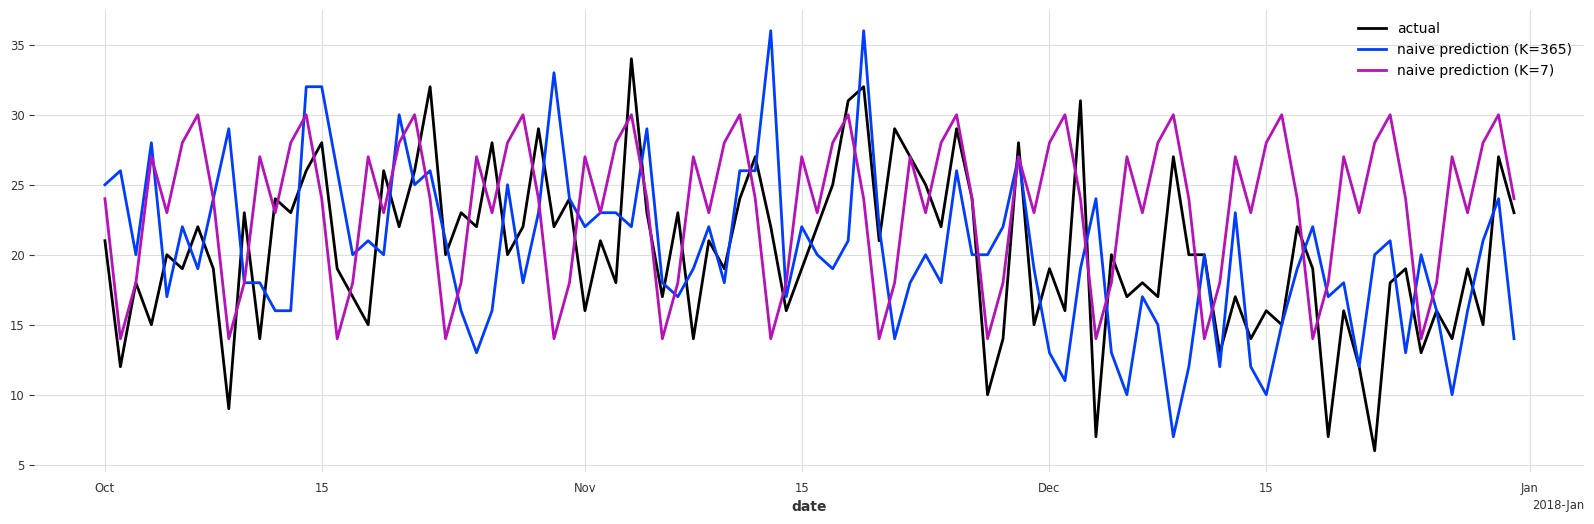

In [77]:
plt.figure(figsize=(20,6))

naive_model_365 = NaiveSeasonal(K=365)
naive_model_365.fit(train)
seasonal_forecast_365 = naive_model_365.predict(len(val))

naive_model_7 = NaiveSeasonal(K=7)
naive_model_7.fit(train)
seasonal_forecast_7 = naive_model_7.predict(len(val))

val.plot(label="actual")
seasonal_forecast_365.plot(label="naive prediction (K=365)")
seasonal_forecast_7.plot(label="naive prediction (K=7)")


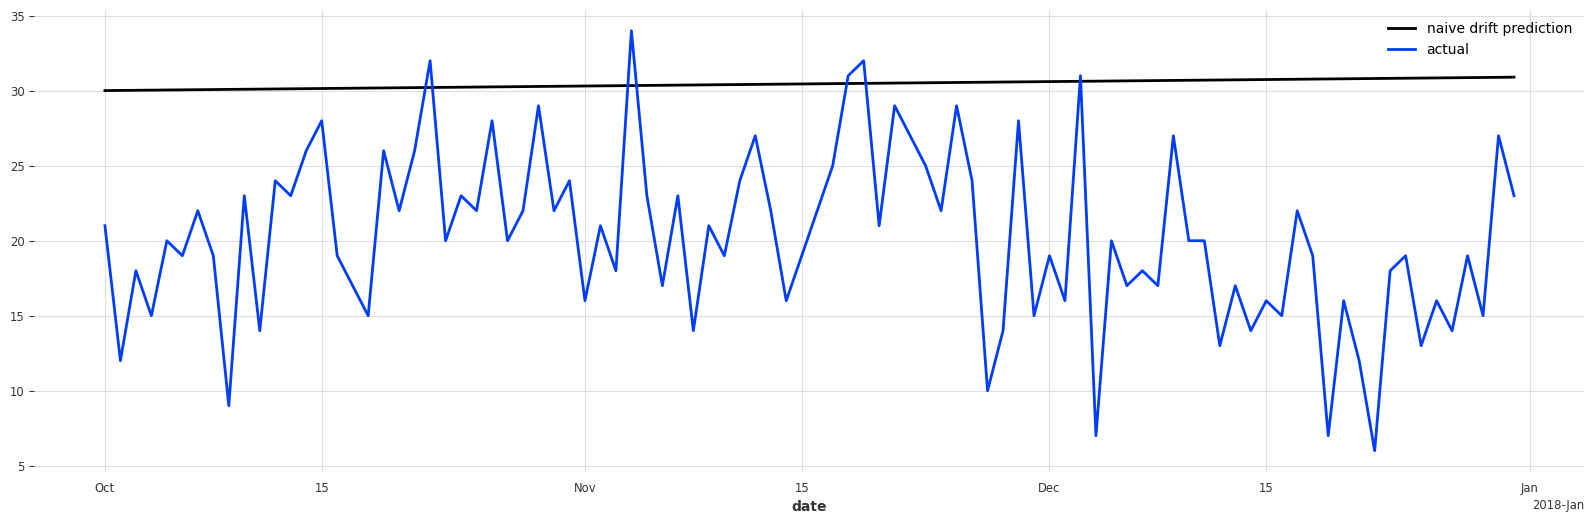

In [78]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(len(val))

plt.figure(figsize=(20,6))
drift_forecast.plot(label="naive drift prediction")
val.plot(label="actual")
plt.legend()

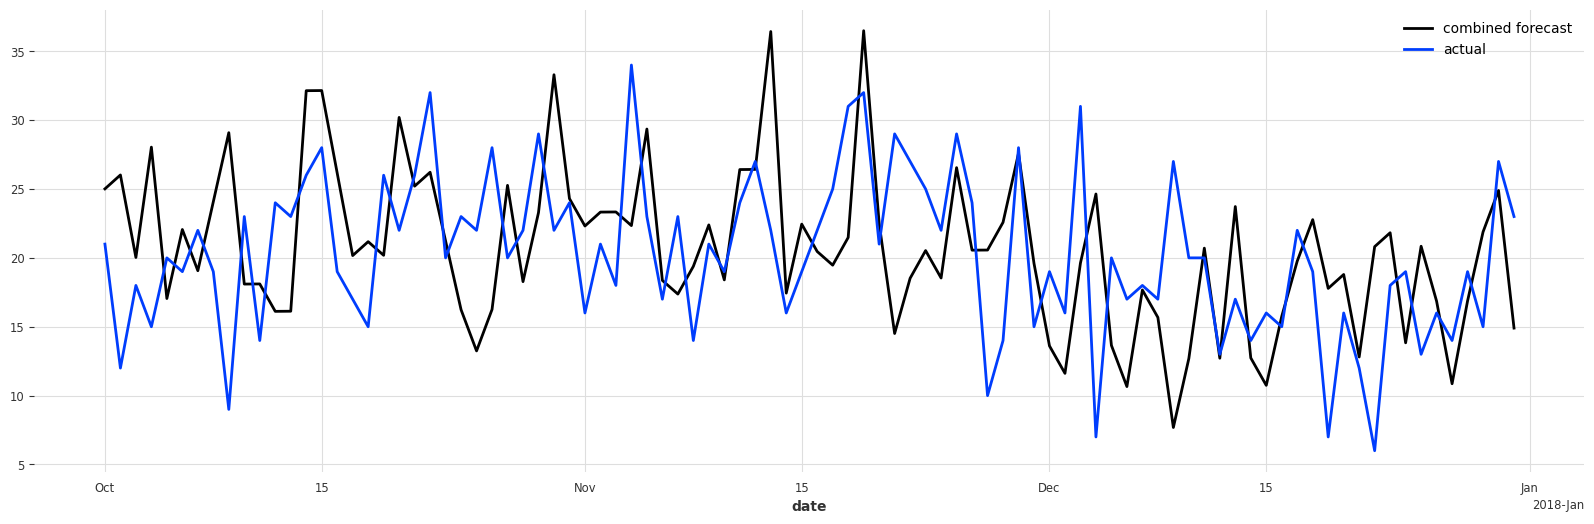

In [79]:
combined_forecast = drift_forecast + seasonal_forecast_365 - train.last_value()
plt.figure(figsize=(20,6))
combined_forecast.plot(label="combined forecast")
val.plot(label="actual")
plt.legend()

<Axes: xlabel='date'>

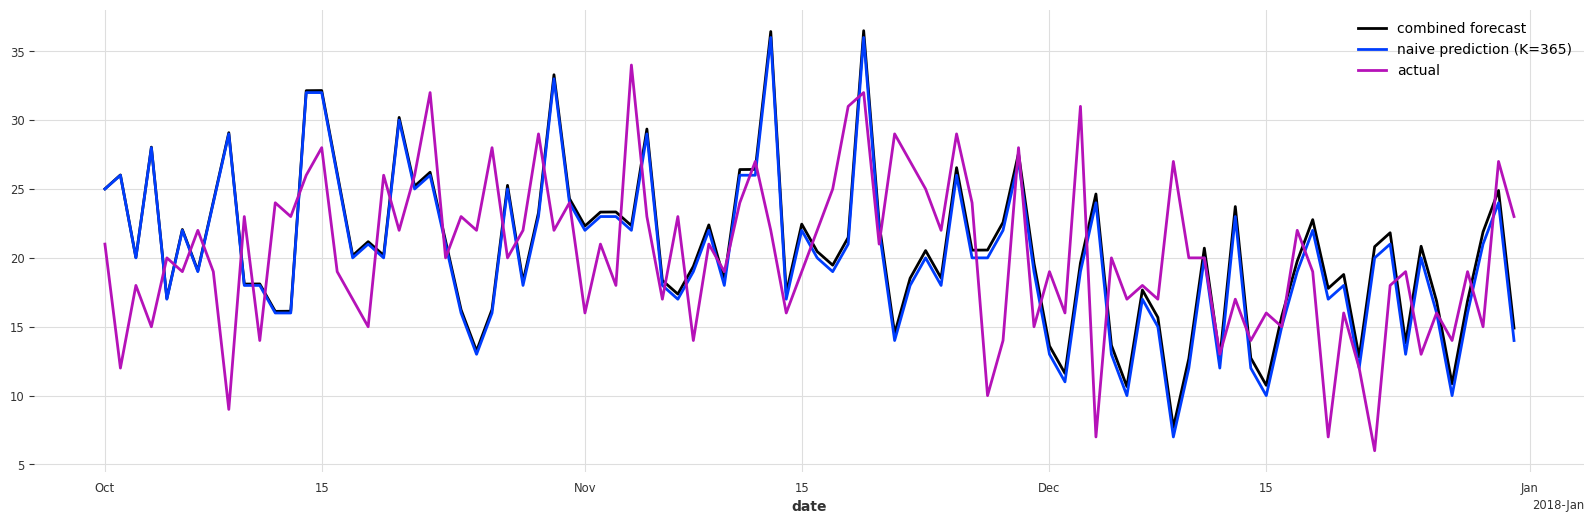

In [80]:
plt.figure(figsize=(20,6))
combined_forecast.plot(label="combined forecast")
seasonal_forecast_365.plot(label="naive prediction (K=365)")
val.plot(label="actual")

# Висновки 8

- Ми спробували протестувати дві гіпотези сезональності 7 днів та 365. Тобто тижневі та рівну сезонність.
- З візуалізації можна сказати що річна сезональність показала більш наближений до правдивого результат.
- Також як додаткова модель ми спробували додати Дріфт до Наівного Баєва, але візуально вони залишилися майже однаковими.

9. Обчисліть помилку прогнозу на валідації наївною моделлю з mape. Далі для всіх моделей необхідно обчислювати помилку прогнозу на валідації.

In [10]:
from darts.metrics import mape

def eval_forecast(model, val, forecast):
  mape_ = mape(val, forecast)
  print(f"model {model} obtains MAPE: {mape_:.2f}%")
  return mape_

In [ ]:
mape_naive_365 = eval_forecast("naive_365", val, seasonal_forecast_365)
mape_naive_7 = eval_forecast("naive_7", val, seasonal_forecast_7)
mape_combined = eval_forecast("combined", val, combined_forecast)
mape_frift = eval_forecast("drift", val, drift_forecast)

model naive_365 obtains MAPE: 33.92%
model naive_7 obtains MAPE: 38.17%
model combined obtains MAPE: 34.26%
model drift obtains MAPE: 68.74%


# Висновки 9

- Наївна модель на 365 (MAPE: 33.92%) показує найменшу похибку серед наївних моделей, що свідчить про те, що річна сезонність є кращим параметром, ніж короткострокові тренди.
- Наївна модель на 7 днів (MAPE: 38.17%) демонструє гіршу точність, що може свідчити що довгострокові залежносіт відіграють більшу роль ніж короткострокові
- Комбінована модель (MAPE: 34.26%) має результат трохи гірший за Наївну модель на 365 днів. 
- Drift (MAPE: 68.74%) має найвищу похибку, оскільки він враховує тільки тренд без сезоності.

10. Натренуйте XBGModel з `darts` для передбачення наших даних. Можна додавати всі додаткові ознаки, які вважаєте за потрібне, наприклад, ознаки з дати. Зробіть висновок про якість моделі.

In [11]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

In [12]:
from darts.metrics import rmse

In [13]:
def plot_actual_vs_forecast(actual, forecast, figsize=(20, 6)):
    plt.figure(figsize=figsize)
    actual.plot(label='Actual', c='grey')
    forecast.plot(label='Forecast', c='red')
    plt.legend()
    plt.title('Actual vs Forecast')
    plt.xlabel('Sales')
    plt.ylabel('Time')
    plt.grid()
    plt.show()


In [28]:


scaler = Scaler()
train_transformed = scaler.fit_transform(train)
test_transformed = scaler.transform(val)

# Побудова моделі XGBoost
model = XGBModel(
    lags = 365,
    output_chunk_length=1,  # Прогнозування на 1 крок вперед
    n_estimators=100,  # Кількість дерев у моделі
    max_depth=3,  # Максимальна глибина кожного дерева
    learning_rate=0.1,  # Коефіцієнт навчання
    subsample=0.8,  # Частка даних для випадкової вибірки кожного дерева
    colsample_bytree=0.8  # Частка ознак, що використовуються для кожного дерева
)

# Тренування моделі
model.fit(train_transformed)
forecast_xgb = model.predict(len(val))



model XGB obtains MAPE: 25.81%


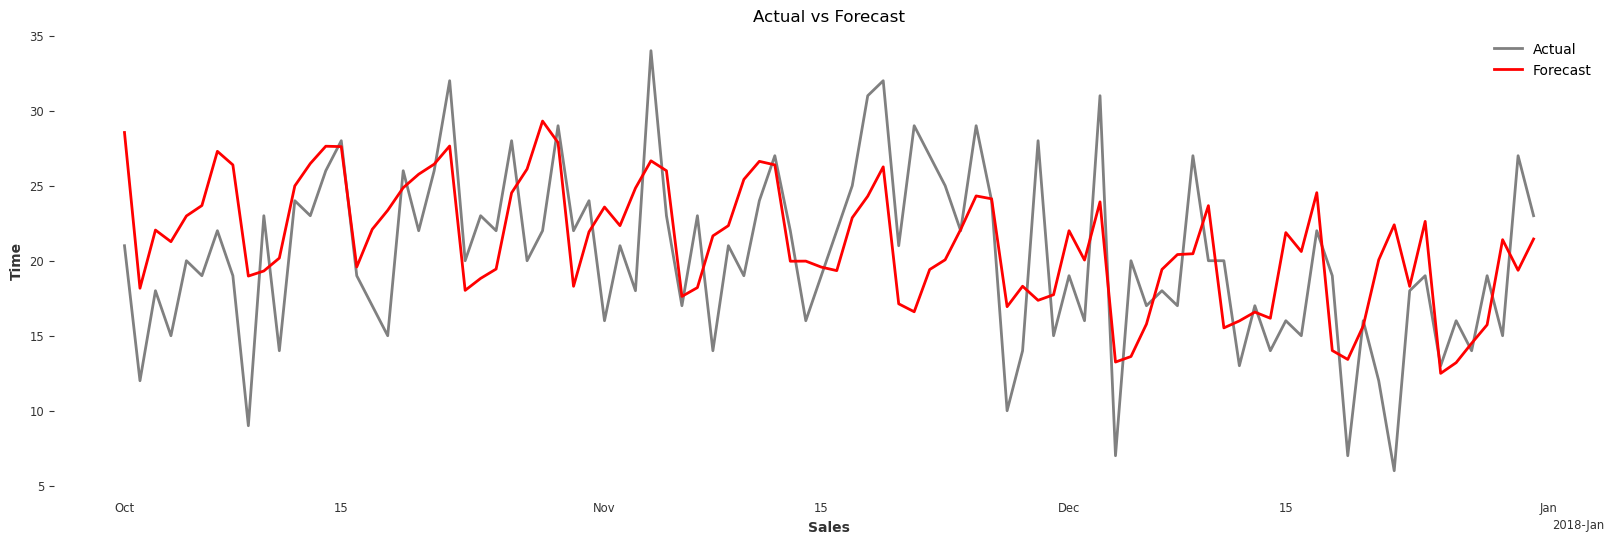

In [29]:
mape_xgb = eval_forecast("XGB", val, scaler.inverse_transform(forecast_xgb))
plot_actual_vs_forecast(val, scaler.inverse_transform(forecast_xgb))

In [31]:
def enrich_with_date_features(df):
    df = df.copy()
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [32]:
df_enriched = enrich_with_date_features(df_11)

date_covariates = TimeSeries.from_dataframe(
    df_enriched, value_cols=['day', 'month', 'year', 'dayofweek', 'dayofyear', 'quarter', 'weekofyear']
)

covariates_train, covariates_val = date_covariates.split_before(pd.Timestamp("2017-09-30"))



In [ ]:
model_enriched = XGBModel(
    lags = [-1,-7, -182, -365, -730], 
    lags_past_covariates=[-1],
    output_chunk_length=1,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
)

model_enriched.fit(train, past_covariates=covariates_train)

forecast_xgb = model_enriched.predict(len(val), past_covariates=covariates_val)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


model XGB with future covariates obtains MAPE: 22.77%


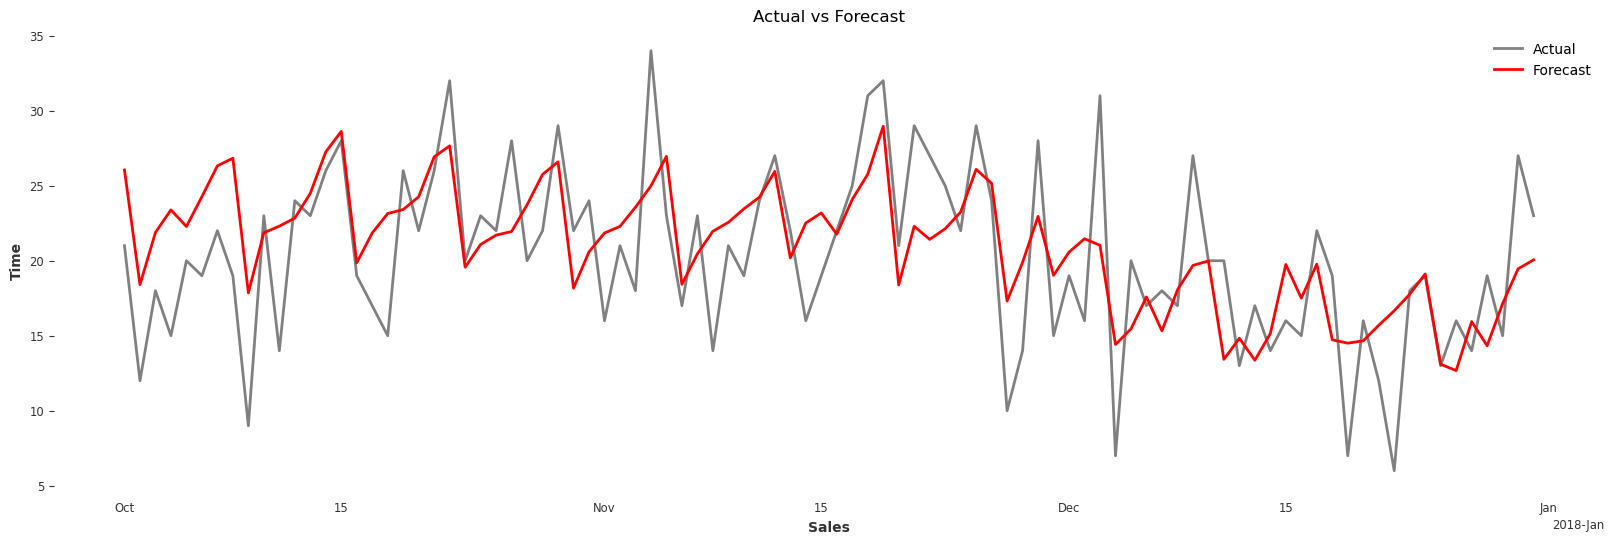

In [38]:
mape_xgb_covariates = eval_forecast("XGB with future covariates", val, forecast_xgb) 
plot_actual_vs_forecast(val, forecast_xgb)

# Висновки 10

- XGB (MAPE: 25.81%) – навіть без додаткових часових ознак демонструє гарну помилку 
- XGB з коваріатами (MAPE: 22.77%) – при тому що додавання часових характеристик (день, місяць, рік, день тижня...) зменшило похибку на 3%. 
Для поточної задачі це відіграє дуже важливу роль та через пряме додавання календарних компонент ми здатні робити кращі прогнози
- Також ми більш налаштували лаги можелі [-1,-7, -182, -365, -730]. Включаюти тижневу, піврічну, річну, дворічну залежності. Що теж значно вплинуло на зменшення помилки


11. Натренуйте модель ExponentialSmoothing та зробіть висновок про її якість.

In [ ]:
from darts.models import ExponentialSmoothing, AutoARIMA

es = ExponentialSmoothing(seasonal_periods=365)
es.fit(train)
forecast_es = es.predict(len(val))

model ES obtains MAPE: 28.97%


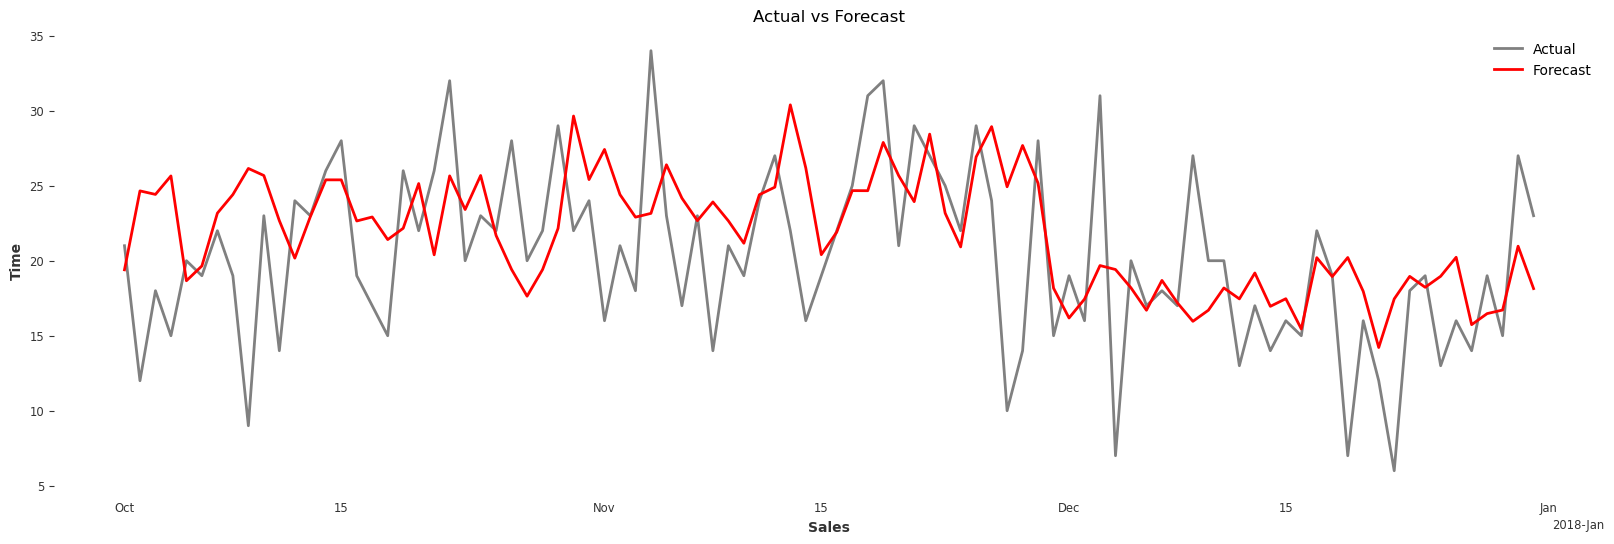

In [41]:
mape_es = eval_forecast("ES", val, forecast_es)
plot_actual_vs_forecast(val, forecast_es)

# Висновки 11

- ExponentialSmoothing (MAPE: 28.97%) - непогана модель. Краща за наівні моделі але програє в точності XGB 

12. Натренуйте модель ARIMA, параметри оберіть самостійно.Зробіть висновок про її якість.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_11['sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.157671
p-value: 0.022569


In [ ]:
from darts.models import ARIMA
arima = ARIMA(p=8, d=0, q=52)
arima.fit(train)
forecast_arima = arima.predict(len(val))

model ARIMA obtains MAPE: 31.13%


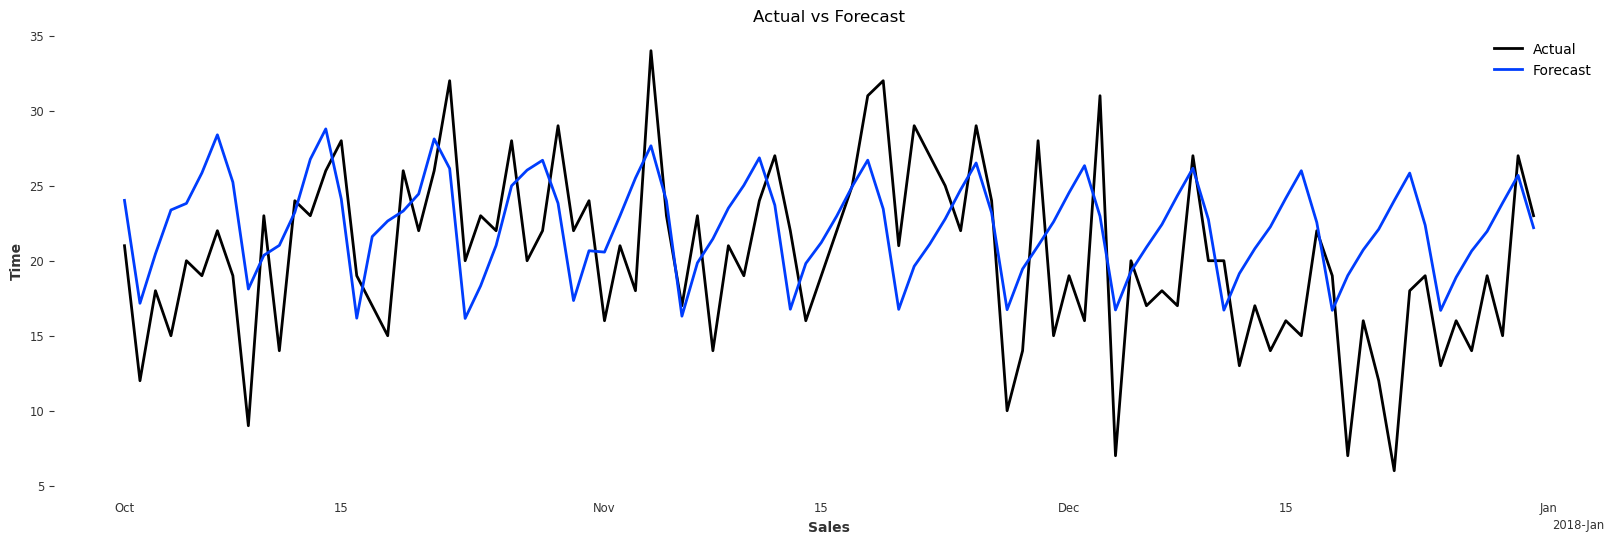

In [462]:
mape_arima = eval_forecast("ARIMA", val, forecast_arima)
plot_actual_vs_forecast(val, forecast_arima)


# Висновки 12
- Для початку перевіремо дані на стаціонарність. За результатами тесту ряд є стаціонарним на рівні значущості 0.05. Отже нам не потрібно його диференціювати і значення d буде дорівнювати 0.
- На основі ресерчу перше значення для **p** встановимо по графіку PACF. Нам терба знати лаг який вперше сильно наближається до довірчого інтервалу. Спробуємо p = 8.
- **q** визначемо за допомогою ACF, де воно вперше сильно наближається до довірчого інтервалу

- В підсумку ARIMA (MAPE: 31.13%) дала не найкращий результат. По графіку видно що патерн занадто одноманітний та модель не вловлює коливання в даних

13. Знайдіть оптимальні параметри моделі ARIMA з допомогою AutoARIMA моделі. Виконайте пошук параметрів, виведіть, які паарметри виявились оптимальними і обчисліть якість моделі. Чи поліпшилась якість порівняно з попереднім експериментом?

In [ ]:
from darts.models import AutoARIMA
autoarima = AutoARIMA(start_p=7, max_p=42, start_q=40, max_q=60, seasonal=True)
autoarima.fit(train)
forecast_autoarima = autoarima.predict(len(val))


model AutoARIMA obtains MAPE: 39.53%


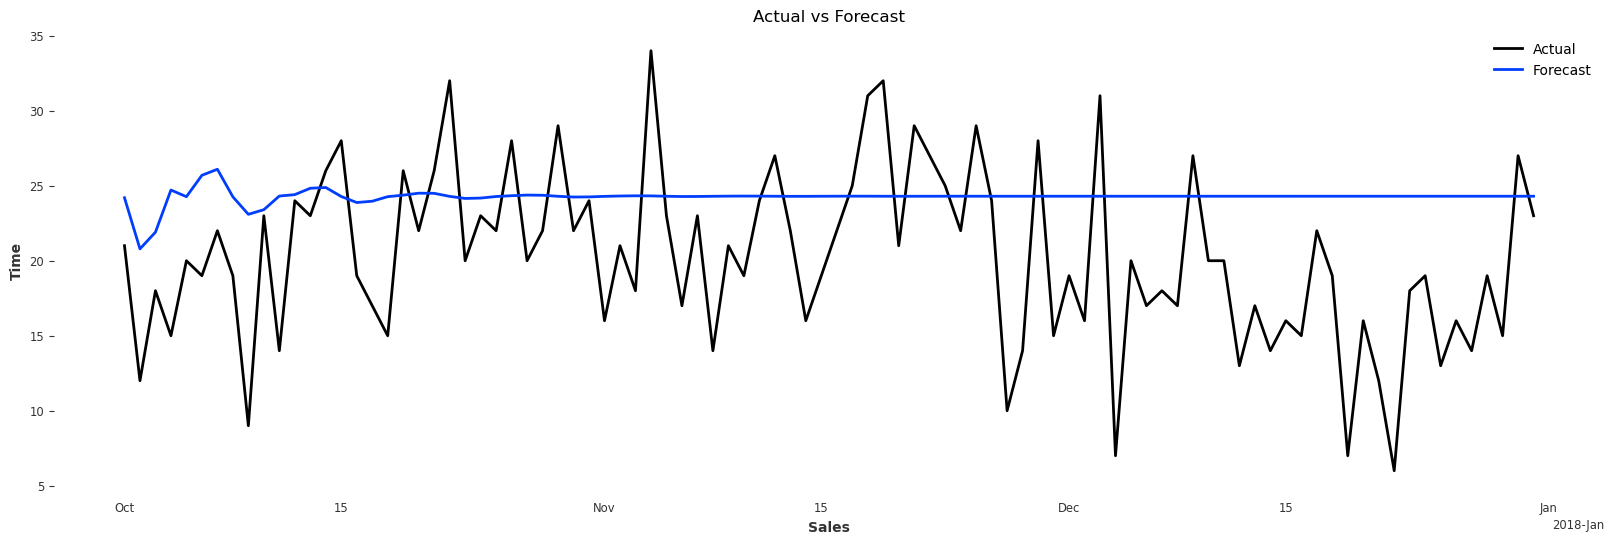

In [465]:
mape_autoarima = eval_forecast("AutoARIMA", val, forecast_autoarima)
plot_actual_vs_forecast(val, forecast_autoarima)

In [484]:
display(autoarima)

AutoARIMA(add_encoders=None, start_p=7, max_p=42, start_q=40, max_q=60, seasonal=True)

In [485]:
autoarima.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1734
Model:               SARIMAX(7, 1, 1)   Log Likelihood               -5286.539
Date:                Mon, 03 Mar 2025   AIC                          10591.078
Time:                        10:08:05   BIC                          10640.196
Sample:                             0   HQIC                         10609.244
                               - 1734                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0346      0.038      0.904      0.366      -0.040       0.109
ar.L2         -0.0799      0.034     -2.379      0.017      -0.146      -0.014
ar.L3         -0.0775      0.033     -2.316      0.021      -0.143      -0.012
ar.L4         -0.0651      0.034     -1.939      0.053      -0.131       0.001
ar.L5         -0.0342      0.032     -1.063      0.288      -0.097       0.029
ar.L6          0.0062      0.030      0.207      0.836      -0.053       0.065
ar.L7          0.2638      0.029      9.042      0.000       0.207       0.321
ma.L1         -0.9071      0.026    -34.233      0.000      -0.959      -0.855
sigma2        26.0956      0.820     31.811      0.000      24.488      27.703
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Висновки 13

- На жаль, модель виявилася гіршою та після 14 днів перестала прогнозувати дані взагалі.
- За результатами отримуємо модель Model:SARIMAX(p=7, d=1, q=1)

14. Натренуйте модель Prophet та зробіть висновок про її якість.

In [22]:
from darts.models import Prophet

prophet_model = Prophet(country_holidays='US' )
prophet_model.fit(train)
forecast_prophet = prophet_model.predict(len(val))

11:00:41 - cmdstanpy - INFO - Chain [1] start processing
11:00:41 - cmdstanpy - INFO - Chain [1] done processing


model Prophet obtains MAPE: 23.49%


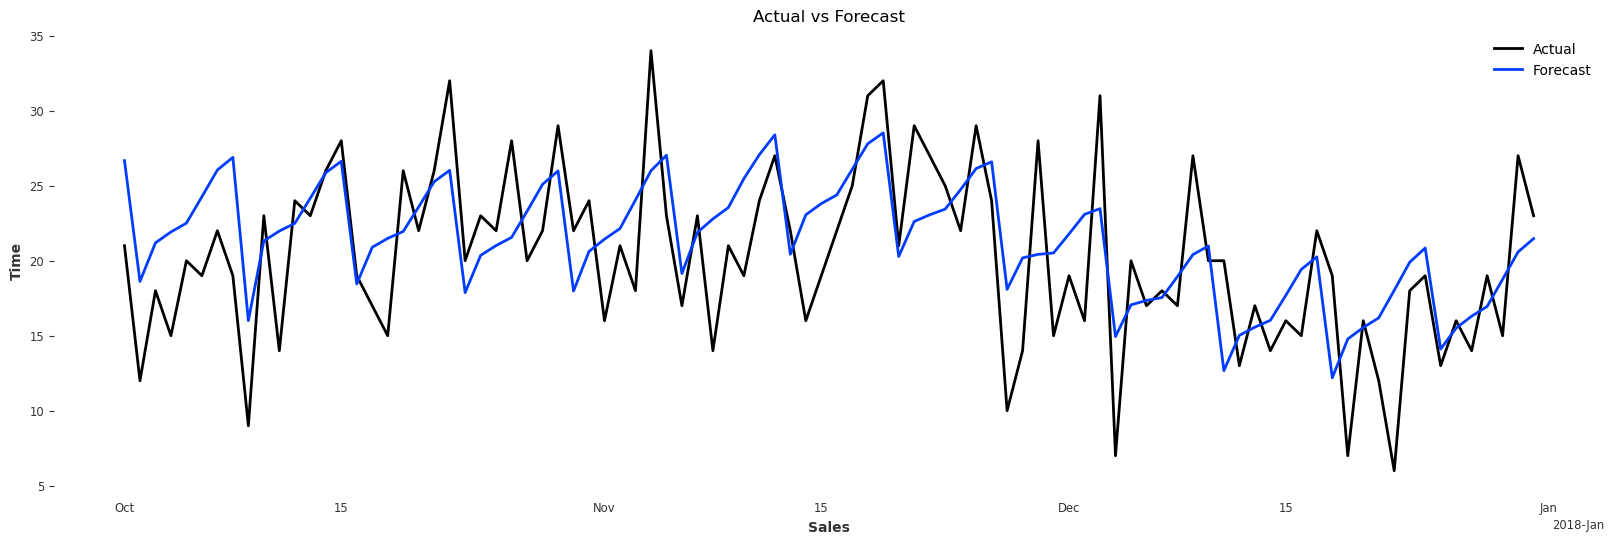

In [24]:
mape_prophet = eval_forecast("Prophet", val, forecast_prophet)
plot_actual_vs_forecast(val, forecast_prophet)

# Висновки 14

- Модель показала непоганий результат особливо коли ми додатково прописали святкові дні (country_holidays='US' )
- Prophet (MAPE: 23.49%) гарно слідує сезонності (спадам та підйомам) але сам патерн прогнозу одноманітний 

15. Натренуйте модель `RNNModel` та зробіть висновок про її якість.

In [25]:
from darts.models import RNNModel

rnn = RNNModel(
    model='LSTM',
    hidden_dim=30,
    input_chunk_length=365,
    training_length=365,
    n_rnn_layers=2,
    output_chunk_length=1,
    random_state=42,
    n_epochs=100
)

rnn.fit(train)
forecast_rnn = rnn.predict(len(val))

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 11.4 K | train
6 | V               | Linear           | 31     | train
-------------------------------------------------------------
11.4 K    Trainable params
0         Non-trainable params
11.4 K    Total params
0.046     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 43/43 [00:14<00:00,  2.91it/s, train_loss=26.40]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 43/43 [00:14<00:00,  2.91it/s, train_loss=26.40]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 24.92it/s]


model RNN obtains MAPE: 48.21%


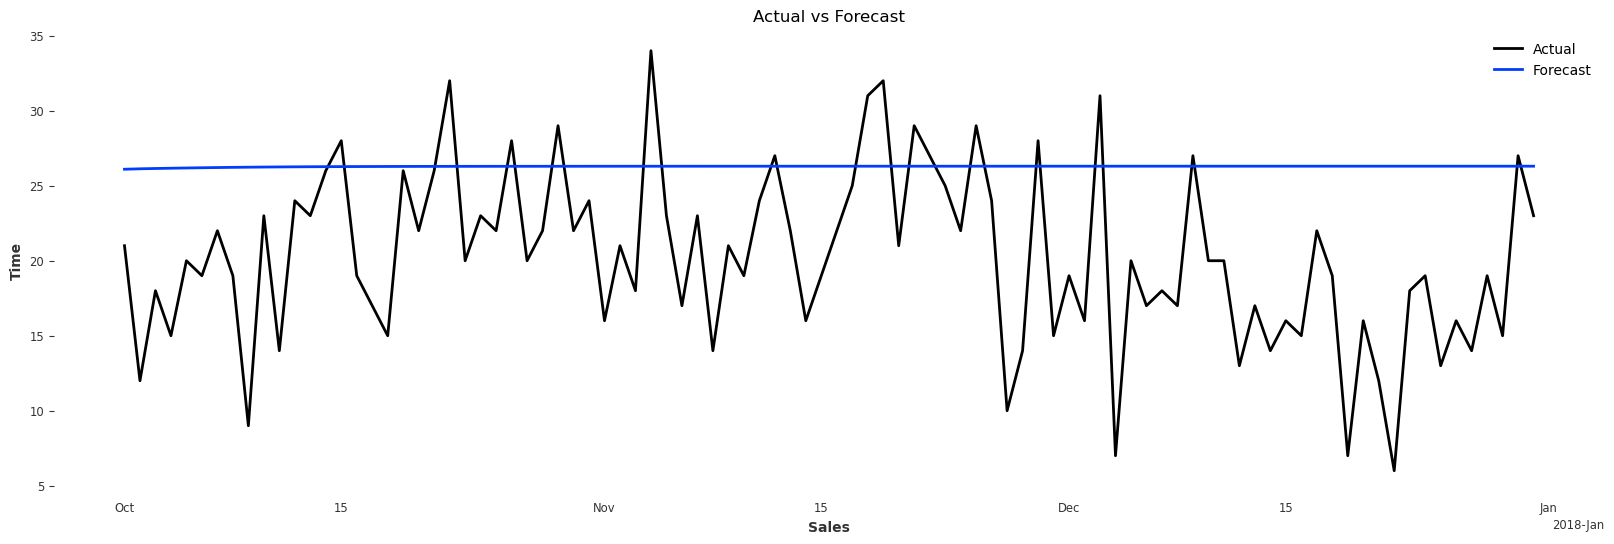

In [26]:
mape_rnn = eval_forecast("RNN", val, forecast_rnn)
plot_actual_vs_forecast(val, forecast_rnn)

# Висновки 15

- LSTM не змогла навчитися. Але ми не стандартезували та не збагачували дані (бо з подібними налаштуваннями модель дуже довго навчалася)
- Для наступної ітерації варто спробувати стандартизувати дані та додати коваріанти аби покращити точність, але через довге навчання модель не виглядає як гарне рішення

16. Виконайте бектест для тої моделі, яка виявилась найкращою у вашому дослідженні на періоді 1 рік з передбаченнями на 1 місяць щоразу. Візуалізуйте як поводилась модель протягом бектесту, яка була точність?

In [37]:
# model_enriched
df_enriched = enrich_with_date_features(df_11)

date_covariates = TimeSeries.from_dataframe(
    df_enriched, value_cols=['day', 'month', 'year', 'dayofweek', 'dayofyear', 'quarter', 'weekofyear']
)

covariates_train, covariates_val = date_covariates.split_before(pd.Timestamp("2017-09-30"))

model_enriched = XGBModel(
    lags = [-1,-7, -182, -365, -730],
    # lags_future_covariates=[-1], 
    lags_past_covariates=[-1],
    output_chunk_length=1,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
)

model_enriched.fit(train, past_covariates=covariates_train)
forecast_xgb = model_enriched.predict(len(val), past_covariates=covariates_val)

_ = eval_forecast("XGB with future covariates", val, forecast_xgb)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


model XGB with future covariates obtains MAPE: 22.77%


In [26]:
df.index.min(), df.index.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [ ]:
hfc_params = {
    "series": series_darts,
    # "start": pd.Timestamp("2016-12-01"),
    "start": pd.Timestamp("2016-11-30"), 
    "forecast_horizon": 30,
    "verbose": True,
}

historical_fcast = model_enriched.historical_forecasts(last_points_only=True, **hfc_params, past_covariates=date_covariates)

model Historical forecast obtains MAPE: 20.10%


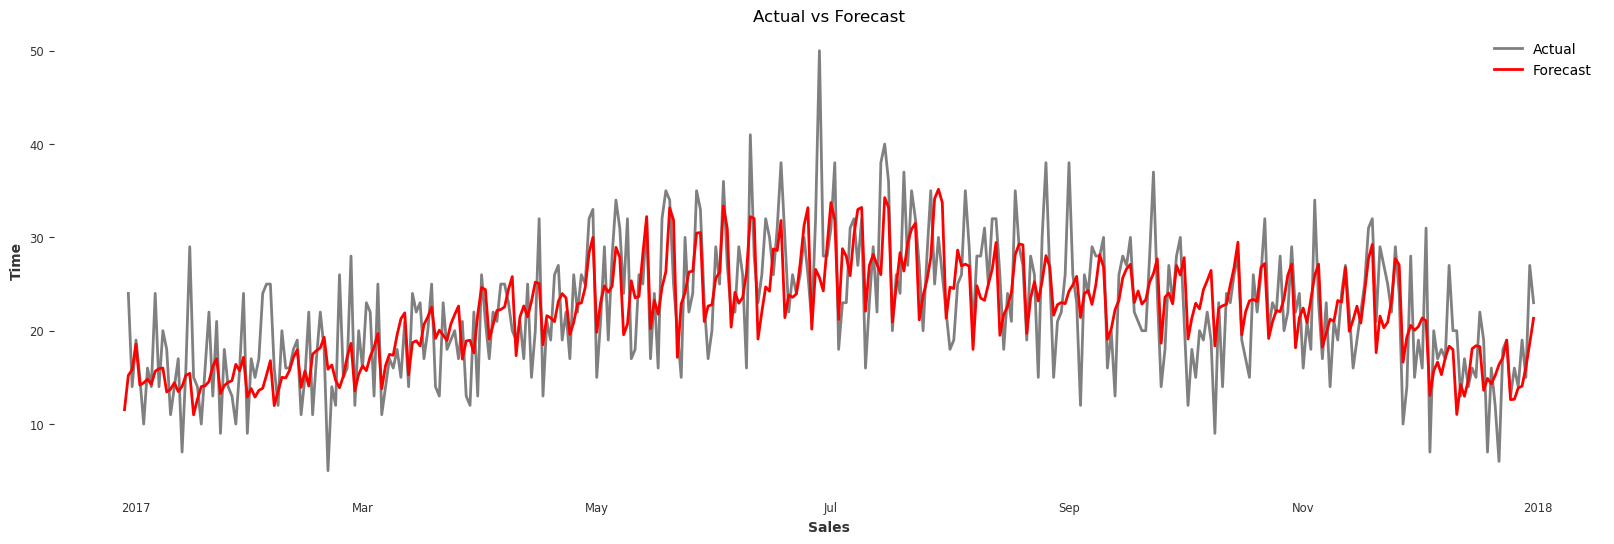

In [82]:
_, after = series_darts.split_before(pd.Timestamp("2016-12-30"))

mape_historical_fcast = eval_forecast("Historical forecast", after, historical_fcast)

plot_actual_vs_forecast(after, historical_fcast)

# Висновки 16

- З усі моделей ми обрали xgb аби зробити бек-тест на кожні наступні 30 днів впродовж року (2017). 
- По результатам бачимо покращення точності (MAPE: 20.10%) але при тому ми досі маємо значні піки в даних які дуже складно зпрогнозувати

| Model                          | MAPE  |
|--------------------------------|-------|
| naive_365                     | 33.92 |
| naive_7                       | 38.17 |
| combined                      | 34.26 |
| drift                         | 68.74 |
| XGB                           | 25.81 |
| **XGB with covariates**           | **22.77**|
| ExponentialSmoothing          | 28.97 |
| ARIMA                         | 31.13 |
| AutoARIMA                     | 39.53 |
| Prophet                       | 23.49 |
| RNN                           | 48.21 |


Всю варіантивність не вгадали, але виглядає непогано!

17. На цьому етапі ви зрозуміли, як моделювати продажі одного айтему з 1 магазину. Як би ви підійшли до задачі прогнозування продажів в наступному місяці для кожного з 50 айтемів в кожному з 10 магазинів? Опишіть загальний підхід
- яку модель ви б використали
- скільки моделей ви б тренували
- обгрунтуйте свій вибір.

# Висновки 17

- Обрана модель має враховувати сезонність та тренд. Через те що наші попередні результати показали гарні результати на XGB я б обрала її, також великим плюсом є можливість додавати нечасові показники\коваріати. Схоже що різні магазину мають різну популярність і ми можемо додати координати\район\штат якісь статичні показники аби покращити точність. Також можна провести додаткові експерименти з Prophet яка зайняла 2ге місце в точності.

- Можна побудувати окрему модель для кожного магазину та продукту (500 моделей). Але краще згрупувати магазини та товари за схожими характеристиками аби зменшити к-ть моделей. Для магазинів розділити на ті що мають стабільно вищі продажі по всім товарам. А товари розділити наскільки товар популярний (непопулярний, середній, популярний) по всіх магазинах. приблизно це може виглядати так (на основі теплової мапи з завдання 2). В підсумку ми матимиме лише (3*2) 6 моделей
    - Мазанини з високими продажами (2, 3, 4, 8, 9, 10) та низькими продажами (1, 5, 6, 7)
    - Товари непопулярні: (1 3 4 5 16 17 23 27 34 40....), Середні: (2 6 7 9 14 19 20 21 26 30 31 32...) Популярні: (8 10 13 15 18 22 25 28 ...)